# Reconhecendo Caracteres das Placas

## Import das bibliotecas e funções

In [1]:
import sys
sys.version

'3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [16]:
import cv2

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(12321)

import pandas as pd

import os, json, itertools, math, time

In [3]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.python.keras.utils import to_categorical

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    # Função importada dos exemplos do SKLearn
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(30,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [5]:
def plot(imagem):
    plt.figure(figsize=(30,12))
    plt.imshow(imagem, cmap="gray")
    plt.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

## Import dos dados

In [6]:
path = "../data/training/"

In [7]:
def get_tboard(nmap):
    l = ["reconhece-digitos-{}", "reconhece-caracteres-{}", "reconhece-digitos-caracteres-"]
    name = l[nmap].format(time.time())
    tbpath = '/Users/juliobguedes/Documents/ufcg/current/ia/logs/{}'.format(name)
    return TensorBoard(log_dir=tbpath)

In [8]:
digitos = []
label_digitos = []
caracteres = []
label_caracteres=[]

# Considera apenas imagens corretas
# Arquivos ._ não são imagens válidas, embora terminem com .png
files = [f for f in os.listdir(path) if f.endswith(".png") and f.startswith("track")]

for arq in files:
        
    img = cv2.imread(path + arq, 0)
    w, c, d = arq.split("-")
    if (d[0] == "1"):
        digitos.append(img)
        label_digitos.append(int(chr(int(c))))
        
    elif (d[0] == "0"):
        caracteres.append(img)
        label_caracteres.append(chr(int(c)))

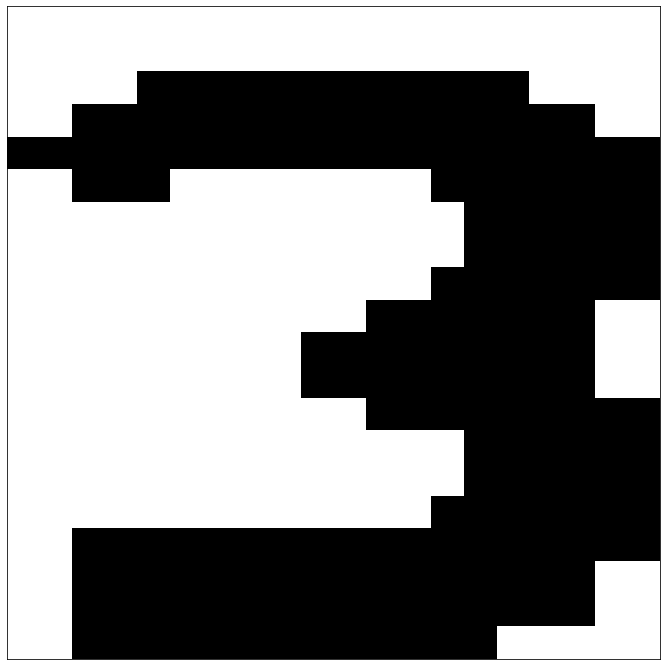

In [9]:
plot(digitos[0])

TypeError: Invalid shape (20, 20, 1) for image data

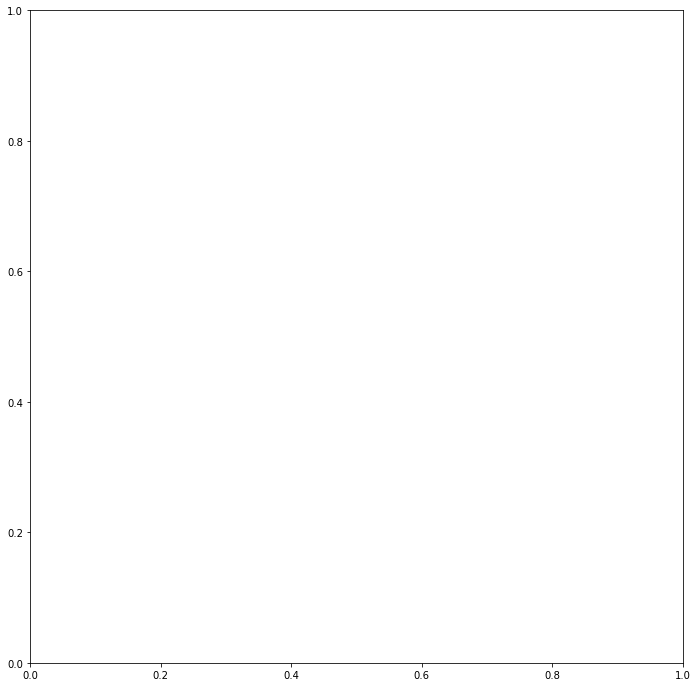

In [26]:
plot(caracteres[0])

In [10]:
valpath = "../data/validation/"
valdigitos = []
vallabel_digitos = []
valcaracteres = []
vallabel_caracteres=[]

# Considera apenas imagens corretas
# Arquivos ._ não são imagens válidas, embora terminem com .png
files = [f for f in os.listdir(valpath) if f.endswith(".png") and f.startswith("track")]

for arq in files:
        
    img = cv2.imread(valpath + arq, 0)
    w, c, d = arq.split("-")
    if (d[0] == "1"):
        valdigitos.append(img)
        vallabel_digitos.append(int(chr(int(c))))
        
    elif (d[0] == "0"):
        valcaracteres.append(img)
        vallabel_caracteres.append(chr(int(c)))

## Preparação dos dados para treino

In [11]:
prop_validacao_digitos = len(valdigitos) / (len(valdigitos) + len(digitos))

digitos.extend(valdigitos)
label_digitos.extend(vallabel_digitos)

prop_validacao_caracteres = len(valcaracteres) / (len(valcaracteres) + len(caracteres))

caracteres.extend(valcaracteres)
label_caracteres.extend(vallabel_caracteres)

PS: Como a função `to_categorical` de Keras não consegue converter letras para variáveis categóricas, optei por usar o padrão onde A = 0, B = 1, C = 3, e assim por diante. Dessa forma, cada letra será convertida em seu valor ASCII subtraido de 65 (valor de A).

In [12]:
digitos = np.array([np.expand_dims(d, axis=2) for d in digitos])
digitos_categoricos = to_categorical(label_digitos, num_classes=10)

In [14]:
caracteres = np.array([np.expand_dims(c, axis=2) for c in caracteres])
caracteres_ord = [ord(c) - 65 for c in label_caracteres]
caracteres_categoricos = to_categorical(caracteres_ord, num_classes=26)

In [29]:
caracteres_categoricos[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [15]:
valdigitos, valcaracteres, vallabel_digitos, vallabel_caracteres = None, None, None, None

## CNN - Digitos

In [17]:
model = Sequential()
model.add(Conv2D(64, (3,3), input_shape=(20, 20, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())

model.add(Dense(256, activation="sigmoid"))
model.add(Dense(512, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(optimizer="adam",
              metrics=["categorical_accuracy"],
              loss="categorical_crossentropy")

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
model.fit(digitos, digitos_categoricos, validation_split=prop_validacao_digitos, epochs=100, callbacks=[get_tboard(0)])

Train on 6330 samples, validate on 3180 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.9692 - categorical_accuracy: 0.6572 - val_loss: 0.6556 - val_categorical_accuracy: 0.7777
Epoch 2/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.4428 - categorical_accuracy: 0.8404 - val_loss: 0.5312 - val_categorical_accuracy: 0.8296
Epoch 3/100
6330/6330 [==============================] - 8s 1ms/sample - loss: 0.4302 - categorical_accuracy: 0.8457 - val_loss: 0.6040 - val_categorical_accuracy: 0.8129
Epoch 4/100
6330/6330 [==============================] - 8s 1ms/sample - loss: 0.2689 - categorical_accuracy: 0.9057 - val_loss: 0.5227 - val_categorical_accuracy: 0.8601
Epoch 5/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.1967 - categorical_accuracy: 0.9318 - val_loss: 0.4743 - val_categorical_accuracy: 0.8881
Epoch 6/100
6330/6330 [==========================

Epoch 47/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.0974 - categorical_accuracy: 0.9675 - val_loss: 0.3593 - val_categorical_accuracy: 0.9270
Epoch 48/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.0628 - categorical_accuracy: 0.9769 - val_loss: 0.3078 - val_categorical_accuracy: 0.9355
Epoch 49/100
6330/6330 [==============================] - 8s 1ms/sample - loss: 0.0599 - categorical_accuracy: 0.9779 - val_loss: 0.3221 - val_categorical_accuracy: 0.9381
Epoch 50/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.0408 - categorical_accuracy: 0.9847 - val_loss: 0.3833 - val_categorical_accuracy: 0.9283
Epoch 51/100
6330/6330 [==============================] - 8s 1ms/sample - loss: 0.0681 - categorical_accuracy: 0.9739 - val_loss: 0.3147 - val_categorical_accuracy: 0.9299
Epoch 52/100
6330/6330 [==============================] - 8s 1ms/sample - loss: 0.0542 - categorical_accuracy: 0.9799 - val_loss: 0.3257 - v

6330/6330 [==============================] - 8s 1ms/sample - loss: 0.0380 - categorical_accuracy: 0.9870 - val_loss: 0.4249 - val_categorical_accuracy: 0.9327
Epoch 95/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.0377 - categorical_accuracy: 0.9864 - val_loss: 0.3733 - val_categorical_accuracy: 0.9299
Epoch 96/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.0514 - categorical_accuracy: 0.9828 - val_loss: 0.4160 - val_categorical_accuracy: 0.9138
Epoch 97/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.0754 - categorical_accuracy: 0.9739 - val_loss: 0.6147 - val_categorical_accuracy: 0.8840
Epoch 98/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.0555 - categorical_accuracy: 0.9821 - val_loss: 0.4903 - val_categorical_accuracy: 0.9182
Epoch 99/100
6330/6330 [==============================] - 7s 1ms/sample - loss: 0.0696 - categorical_accuracy: 0.9771 - val_loss: 0.5034 - val_categorica

In [19]:
testpath = "../data/testing/"
testdigitos = []
testlabel_digitos = []
testcaracteres = []
testlabel_caracteres=[]

# Considera apenas imagens corretas
# Arquivos ._ não são imagens válidas, embora terminem com .png
files = [f for f in os.listdir(testpath) if f.endswith(".png") and f.startswith("track")]

for arq in files:
        
    img = cv2.imread(testpath + arq, 0)
    w, c, d = arq.split("-")
    if (d[0] == "1"):
        testdigitos.append(img)
        testlabel_digitos.append(int(chr(int(c))))
        
    elif (d[0] == "0"):
        testcaracteres.append(img)
        testlabel_caracteres.append(chr(int(c)))

In [20]:
testdigitos = np.array([np.expand_dims(d, axis=2) for d in testdigitos])

In [38]:
testcaracteres = np.array([np.expand_dims(c, axis=2) for c in testcaracteres])

In [21]:
pred = model.predict(testdigitos)
rpred = [np.argmax(i) for i in pred]

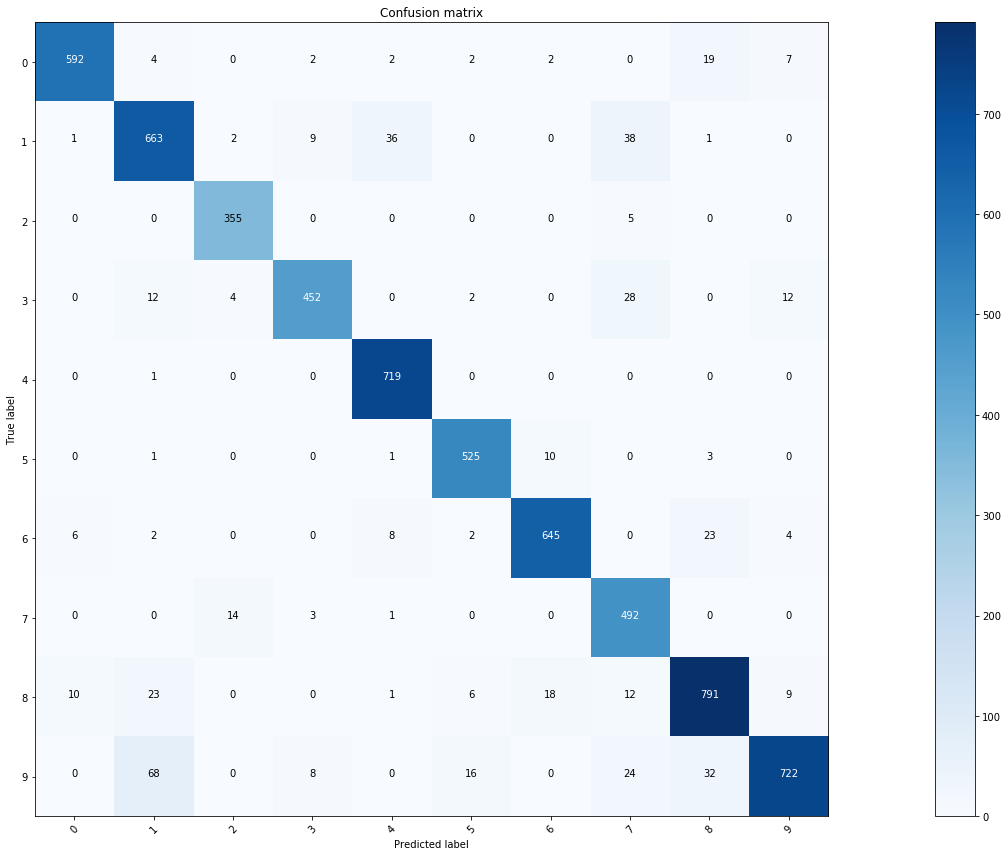

In [22]:
matriz = confusion_matrix(testlabel_digitos, rpred)
plot_confusion_matrix(matriz, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [23]:
accuracy_score(testlabel_digitos, rpred)

0.9234108527131782

## CNN - Caracteres

In [33]:
model2 = Sequential()
model2.add(Conv2D(64, (3,3), input_shape=(20, 20, 1)))
model2.add(MaxPooling2D((2,2)))
model2.add(Flatten())

model2.add(Dense(256, activation="sigmoid"))
model2.add(Dense(512, activation="relu"))
model2.add(Dense(256, activation="sigmoid"))
model2.add(Dense(512, activation="relu"))
model2.add(Dense(26, activation="softmax"))

model2.compile(optimizer="adam",
              metrics=["categorical_accuracy"],
              loss="categorical_crossentropy")

In [34]:
model2.fit(caracteres, caracteres_categoricos,
           validation_split=prop_validacao_caracteres, epochs=100,
           callbacks=[get_tboard(1)])

Train on 5130 samples, validate on 2550 samples
Epoch 1/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 2.2357 - categorical_accuracy: 0.3715 - val_loss: 1.8283 - val_categorical_accuracy: 0.5008
Epoch 2/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 1.1768 - categorical_accuracy: 0.6331 - val_loss: 1.2835 - val_categorical_accuracy: 0.6769
Epoch 3/100
5130/5130 [==============================] - 5s 1ms/sample - loss: 0.5632 - categorical_accuracy: 0.8172 - val_loss: 1.2185 - val_categorical_accuracy: 0.7161
Epoch 4/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.3948 - categorical_accuracy: 0.8602 - val_loss: 1.2754 - val_categorical_accuracy: 0.7518
Epoch 5/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.3173 - categorical_accuracy: 0.8867 - val_loss: 1.5841 - val_categorical_accuracy: 0.7294
Epoch 6/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.3820 - categoric

5130/5130 [==============================] - 6s 1ms/sample - loss: 0.0845 - categorical_accuracy: 0.9698 - val_loss: 1.6255 - val_categorical_accuracy: 0.8098
Epoch 49/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.0972 - categorical_accuracy: 0.9630 - val_loss: 1.7155 - val_categorical_accuracy: 0.7949
Epoch 50/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.0992 - categorical_accuracy: 0.9602 - val_loss: 1.6624 - val_categorical_accuracy: 0.8035
Epoch 51/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.0936 - categorical_accuracy: 0.9635 - val_loss: 1.7120 - val_categorical_accuracy: 0.7961
Epoch 52/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.0948 - categorical_accuracy: 0.9632 - val_loss: 1.7376 - val_categorical_accuracy: 0.7812
Epoch 53/100
5130/5130 [==============================] - 7s 1ms/sample - loss: 0.1209 - categorical_accuracy: 0.9548 - val_loss: 1.8005 - val_categorica

Epoch 96/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.1013 - categorical_accuracy: 0.9596 - val_loss: 2.0562 - val_categorical_accuracy: 0.7584
Epoch 97/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.1075 - categorical_accuracy: 0.9591 - val_loss: 1.8746 - val_categorical_accuracy: 0.7831
Epoch 98/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.0994 - categorical_accuracy: 0.9616 - val_loss: 1.8724 - val_categorical_accuracy: 0.7769
Epoch 99/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.0935 - categorical_accuracy: 0.9616 - val_loss: 1.8835 - val_categorical_accuracy: 0.7702
Epoch 100/100
5130/5130 [==============================] - 6s 1ms/sample - loss: 0.0983 - categorical_accuracy: 0.9598 - val_loss: 1.9048 - val_categorical_accuracy: 0.7816


In [39]:
pred_c = model2.predict(testcaracteres)
rpred_c = [chr(np.argmax(i) + 65) for i in pred_c]

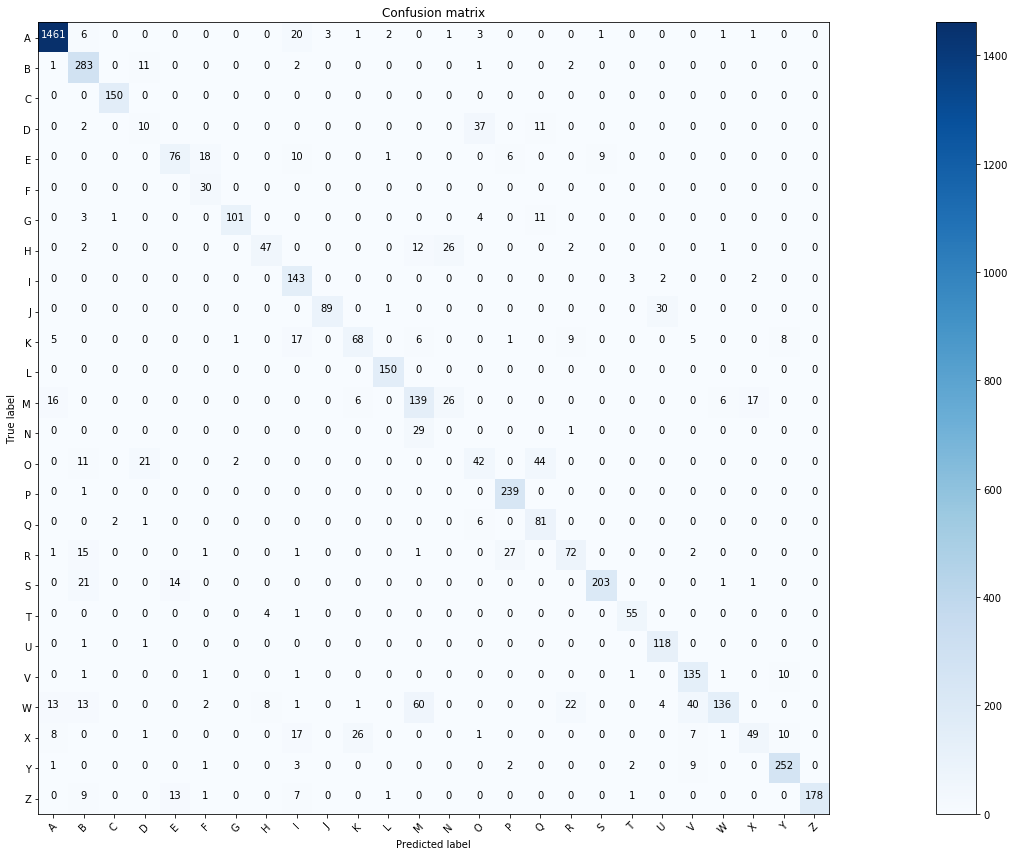

In [40]:
matriz = confusion_matrix(testlabel_caracteres, rpred_c)
plot_confusion_matrix(matriz, classes=[chr(i) for i in range(65, 65+26)])

In [41]:
accuracy_score(testlabel_caracteres, rpred_c)

0.8298651252408478